<html>
    <summary></summary>
         <div> <p></p> </div>
         <div style="font-size: 20px; width: 800px;">
              <h1>
               <left>CME fitting example.</left>
              </h1>
              <p><left>============================================================================</left> </p>
<pre>Course: ASU CBP Summer School 2025
Instructor: Dr. Douglas Shepherd
Contact Info: douglas.shepherd@asu.edu
Authors: Dr. Douglas Shepherd
</pre>
         </div>
    </p>

</html>

<details>
  <summary>Copyright info</summary>

```
Copyright 2025 Douglas Shepherd

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```
<details>



<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/QI2lab/2025-CBP-SummerSchool/blob/main/Module3-ModelingBiochemicalReactions/M3D_Fitting_Models_to_Data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/QI2lab/2025-CBP-SummerSchool/blob/main/Module3-ModelingBiochemicalReactions/M3D_Fitting_Models_to_Data.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

----------
# Learning Objectives for this example:
--------------

After this group exercise, you should be able to:
* Run a CME for a birth-decay process
* Properly compare CME solutions to experimental data
* Plot solutions

![alt text](https://github.com/QI2lab/2025-CBP-SummerSchool/blob/main/Module3-ModelingBiochemicalReactions/Figures/StoichiometryAndPropensity_2023/Slide27.png?raw=1)

In [1]:
# Load necessary packages and libraries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
rc('animation', html='jshtml')
figSize=600
rng = np.random.default_rng()

# 1. Simulate birth-decay using random parameters

### Create the birth-decay model system
This system will have three randomly drawn parameters:
1. $N_{initial}^{experiment}$, the number of starting molecules.
2. $k_{1}^{experiment}$, the birth rate.
2. $k_{2}^{experiment}$, the decay rate.

### Define the functions needed to run an SSA at set time points

In [2]:
def initial_condition():
  """Create initial condition for simulated experiment

  Returns
  -------
  x0: np.ndarray
    initial condition for simulated experiment
  """

  # Here we have a single species (N=1) with units x0 = (mg/mL)
  x0=np.array([rng.uniform(low=5,high=10)])

  return x0

def stoichometry():
  """Create stoichiometry matrix

  Returns
  -------
  S: np.ndarray
    stoichiometry matrix
  """

  # Define the stoichiometry matrix as a 1 (species) by 2 (reaction) numpy array,
  S=np.array([[1,-1]])

  return S

def propensities():
  """Create propensities

  Returns
  -------
  pars: dict
    dictionary of propensities
  """

  # Define the reaction rate parameters as a dictionary
  k1_experiment = rng.uniform(low=0.15, high=0.35)
  k2_experiment = rng.uniform(low=0.01, high=0.1)
  pars = {'k1': k1_experiment, 'k2': k2_experiment}
  # Units are:  k1 = (mg/mL) / minute
  #             k2 = 1 / minute

  return pars

  # Define the reaction rate (propensity) functions
def W(x,t,pars):
  """Define propensity functions

  Parameters
  ----------
  x: np.ndarray
    population vector
  t: np.ndarray
    time vector
  pars: dict
    dictionary of parameters

  Returns
  -------
  np.ndarray
    propensity vector
  """

  return np.array([pars['k1'],pars['k2']*x[0]])

In [3]:
# Run the many SSAs using the random parameters
# Let's define a simple function that computes the time of the next reaction given our propensity functions:
def next_time(x, t, pars):
  """Compute the time of the next reaction

  Parameters
  ----------
  x: np.ndarray
    population vector
  t: np.ndarray
    time vector
  pars: dict
    dictionary of parameters

  Returns
  -------
  float
    time of next reaction
  """

  return -np.log(np.random.rand()) / np.sum(W(x, t, pars))

# Let's define a simple function that computes the index of the next reaction given our propensity functions:
def next_reaction(x, t, pars):
  """Determine the index of the next reaction

  Parameters
  ----------
  x: np.ndarray
    population vector
  t: np.ndarray
    time vector
  pars: dict
    dictionary of parameters

  Returns
  -------
  int
    index of next reaction
  """

  Wx = W(x, t, pars)
  Wx_sum = np.sum(Wx)
  r = np.random.rand()
  i = 0
  W_sum = Wx[0]
  while W_sum / Wx_sum < r:
      i += 1
      W_sum += Wx[i]
  return i

# Gillespie algorithm to return the trajectories at specific time points.
def gillespie1(x0, t0, tmax, S, pars, trajectory_times):
  """Run Gillespie algorithm to return the trajectories at specific time points.

  Parameters
  ----------
  x0: np.ndarray
    initial condition for simulated experiment
  t0: float
    initial time for simulated experiment
  tmax: float
    final time for simulated experiment
  S: np.ndarray
    stoichiometry matrix
  pars: dict
    dictionary of propensities

  Returns
  -------
  np.ndarray
    trajectories at specific time points
  """

  # Initialize the time and the state
  t = t0
  x = x0

  # Initialize the output
  states = np.zeros((len(trajectory_times), len(x0)))

  # next time index
  nextTimeIndex = 0

  # Run the simulation
  while t < tmax:
      # Compute the time of the next reaction
      tau = next_time(x, t, pars)
      t += tau

      # Check to see if we need to save the state
      while t >= trajectory_times[nextTimeIndex]:
          states[nextTimeIndex] = x
          nextTimeIndex += 1
          if nextTimeIndex >= len(trajectory_times):
              return np.squeeze(states)

      # Compute the index of the next reaction
      i = next_reaction(x, t, pars)

      # Update the state
      x = x + S[:, i]

### Run the simulated experiment
  
We will treat this like a simulated experiment, where you have limited time and resources. For our purposes, that means that the number of experiments * number of time points has to be less than 500 ($n_{traj} \times n_{timepoints} <= 500$)

In [60]:
def run_simulated_experiment(n_traj,t_max,n_timepoints):
  """Run the simulated experiment

  Parameters
  ----------
  n_traj: int
    number of trajectories to run
  t_max: float
    final time for simulated experiment
  n_timepoints: int
    number of time points to save

  Returns
  -------
  trajectories: np.ndarray
    trajectories at specific time points
  trajectory_times: np.ndarray
    time points to save
  """

  x0 = initial_condition()
  S = stoichometry()
  pars = propensities()

  assert n_traj * n_timepoints <= 5000, "n_traj * n_timepoints must be less than 5000"
  trajectory_times = np.linspace(0,t_max,n_timepoints)

  # Initialize the results
  trajectories = np.zeros((n_traj, len(trajectory_times)))
  for i in range(n_traj):
      trajectories[i,:] = gillespie1(x0, 0, t_max, S, pars, trajectory_times)

  return trajectories, trajectory_times, (x0,pars['k1'],pars['k2'])

n_traj = 100
t_max = 100
n_timepoints = 50
experimental_results, trajectory_times, experimental_parameters = run_simulated_experiment(n_traj,t_max,n_timepoints)

### Plot the simulated experiment results

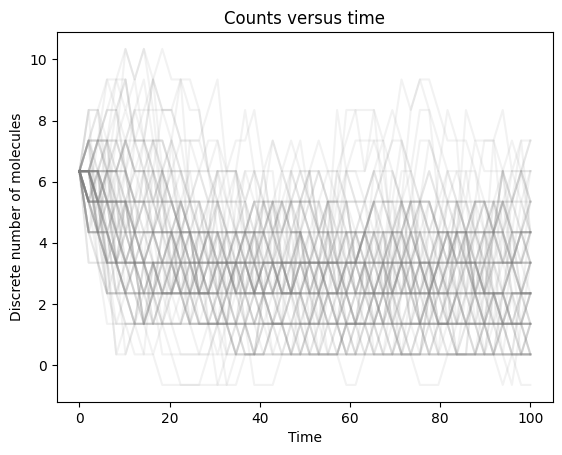

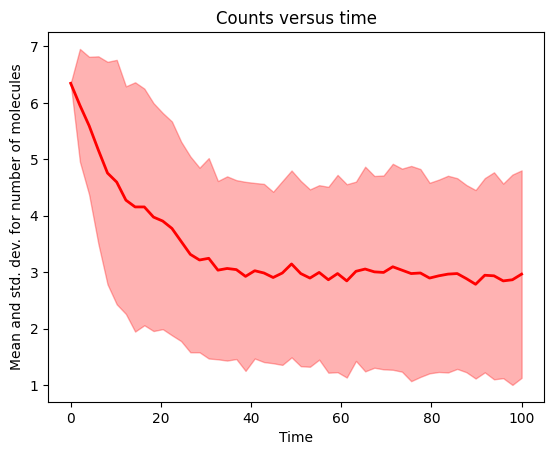

In [61]:
# Plot the results for the molecule counts
plt.plot(trajectory_times, experimental_results.T, color='gray', alpha=0.1)
plt.xlabel('Time')
plt.ylabel('Discrete number of molecules')
plt.title('Counts versus time')
plt.show()

plt.plot(trajectory_times, np.mean(experimental_results, axis=0), color='r', linewidth=2)
plt.fill_between(trajectory_times, np.mean(experimental_results, axis=0) - np.std(experimental_results, axis=0), np.mean(experimental_results, axis=0) + np.std(experimental_results, axis=0), color='r', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Mean and std. dev. for number of molecules')
plt.title('Counts versus time')
plt.show()

In [62]:
print(f"Simulation parameters are x(0) = {round(experimental_parameters[0][0],2)}; k1 = {round(experimental_parameters[1],2)}; k2 = {round(experimental_parameters[2],2)}")

Simulation parameters are x(0) = 6.35; k1 = 0.24; k2 = 0.08


# 2. Fitting the data

### Strategy

1. Write a modular CME.
2. Decide on a fitting routine to use (KS test, KL divergence, etc...)
3. Run the fitting and compare the obtained $k_1$, $k_2$ to the known $k_1^{experiment}$, $k_2^{experiment}$
4. Discuss how to improve your parameter estimates
5. Think about why $k_1/k_2$ is the important scale for this problem (HINT: solve the ODE or ask the computer to analytically solve the ODE).

In [10]:
from scipy.optimize import minimize
from scipy.linalg import expm
from scipy.stats import kstest, entropy

### Use an CME model (Module 3C)

As we could see with the SSA approach, it is not very robust due to the random nature of the algorithm. Unless we run thousands of individual simulations, it is difficult to produce a stable result (try this yourself!).

This is where we can use the CME approach, because it exactly solves for the probability distribution at each time point $t$.

### Define the CME (see module 3C slides)

In [31]:
def W_CME(x,t,pars):
  """Define propensity matrix.

  Parameters
  ----------
  x: np.ndarray
    population vector
  t: np.ndarray
    time vector
  pars: dict
    dictionary of parameters

  Returns
  -------
  np.ndarray
    propensity matrix
  """

  return np.array([pars['k1']*np.ones_like(x[0]),pars['k2']*x[0]])

def build_inf_gen(S, W, states, pars, t=0):
  """Build the infinitesimal generator matrix for a continuous time Markov chain.

  Parameters
  ----------
  S: np.ndarray
    stoichiometry matrix
  W: np.ndarray
    propensity matrix
  states: np.ndarray
    state vector
  pars: dict
    dictionary of parameters
  t: float
    time

  Returns
  -------
  infGens: np.ndarray
    infinitesimal generator matrix
  sink: np.ndarray
    sink state vector
  infGenTotal: np.ndarray
    total infinitesimal generator matrix
  """

  # Determie the number of species, states and reactions
  nSpecies, nStates = states.shape
  nReactions = S.shape[1]

  # Compute the propensity functions for all states.
  propensities = W_CME(states, t, pars)

  # Step through each reaction
  infGens = []
  infGen = np.zeros((nStates+1,nStates+1))
  sink = np.zeros(nStates)
  for mu in range(nReactions):
      # Compute flow of probability out of all states due to reaction mu
      infGens.append(-np.diag(propensities[mu,:]))

      for i in range(nStates):
          # Compute the states after the reaction mu
          newState = (states[:,i] + S[:,mu]).reshape(-1,1)

          # Check if the state is non-negative
          if np.all(newState >= 0):
              # Find the index of the state
              try:
                  j = np.where((states == newState).all(axis=0))[0][0]
                  infGens[mu][j,i] += propensities[mu,i]

              except:
                  sink[i] += propensities[mu,i]
      # Add the current reaction to the infinitesimal generator
      infGen[:nStates,:nStates] += infGens[mu]

  # Add the sink as the final row of the infinitesimal generator
  infGen[nStates,:nStates] = sink

  return infGens, sink, infGen

def generate_states(max_molecules):
  """Generate state vector.

  Parameters
  ----------
  max_molecules: int
    maximum number of molecules

  Returns
  -------
  states: np.ndarray
    state vector
  """

  states = np.zeros((1, max_molecules+2))
  for i in range(max_molecules+1):
      states[:,i] = [i]
  states[:,max_molecules+1] = [max_molecules]
  return states

def cme_model(t, x0, k1, k2, max_molecules):
  """Run CME model.

  Parameters
  ----------
  t: np.ndarray
    time vector
  x0: float
    initial number of molecules
  k1: float
    rate constant for birth
  k2: float
    rate constant for decay
  max_molecules: int
    maximum number of molecules

  Returns
  -------
  np.ndarray
    population vector
  """

  states = generate_states(max_molecules)
  pars = {'k1': k1, 'k2': k2}
  S = stoichometry()
  infGens, sink, infGenTotal = build_inf_gen(S, W_CME, states, pars, t)
  idx0 = np.where([(states[:,i]==round(x0,0)).all() for i in range(states.shape[1])])

  P0 = np.zeros(infGenTotal.shape[1])
  P0[idx0] = 1
  deltaT = t[1]-t[0]

  expmAt = expm(infGenTotal*deltaT)

  # # Solve the ODE
  P_vector = np.zeros((len(t), len(P0)))
  P_vector[0,:] = P0
  for i in range(1, len(t)):
    P_vector[i,:] = expmAt @ P_vector[i-1,:]

  return P_vector

In [73]:
def cme_error_function(params, t, data, max_molecules, debug):
  """Fit CME to experimental data using KL-divergence.

  Parameters
  ----------
  params: np.ndarray
    parameters to fit
  t: np.ndarray
    time vector
  data: np.ndarray
    experimental data
  max_molecules: int
    maximum number of molecules
  debug: bool
    whether to print debug information

  Returns
  -------
  float
    sum of KL-divergence between CME and experimental data for all timepoints
  """

  # run CME for these parameters
  x0, k1, k2 = params
  cme_solution = cme_model(trajectory_times, x0,k1,k2,max_molecules)

  # generate normalized histogram of data on same grid as CME solution
  data_hist = []
  for t_idx in range(len(t)):
    temp, _ = np.histogram(data[:,t_idx], bins=max_molecules,range=(0,max_molecules), density = True)
    data_hist.append(temp)
  data_hist = np.array(data_hist)

  # remove sink state from CME solution
  usable_cme_solution = cme_solution[:,0:max_molecules]

  # set any values less than 1e-12 to 1e-12 to avoid divide by zero errors
  usable_cme_solution[usable_cme_solution<1e-12]=1e-12
  data_hist[data_hist<1e-12]=1e-12

  # calculate sum over entropy between the two distributions
  metric = np.sum(entropy(usable_cme_solution,data_hist,axis=1))

  # output solver updates if requested
  if debug:
    print(f"x0: {x0}, k1: {k1}, k2: {k2}")
    print(f"metric: {metric}")

  return metric

### Run optimization

In [74]:
# Set initial guess
initial_guess_cme = [6,0.5,0.5]

# Define bounds for the parameters [x0, k1, k2]
# These bounds should be reasonable based on the expected values in your system
bounds_cme = [(0, 20), (0, 1), (0, 1)]

# Define max molecules
max_molecules = 200

# Set debug = True (output information on each interation) or False (no output)
debug = False

# Fit the CME model to the normalized data histogram at the observed time points using minimize
result_cme = minimize(
  cme_error_function,
  initial_guess_cme,
  args=(trajectory_times, experimental_results, max_molecules, debug),
  bounds=bounds_cme
)

# Extract the fitted parameters
popt_cme = result_cme.x

In [75]:
print(f"Fitted parameters are x(0) = {round(popt_cme[0],2)}; k1 = {round(popt_cme[1],2)}; k2 = {round(popt_cme[2],2)}; k1/k2 = {round(popt_cme[1]/popt_cme[2],2)}")
print(f"Correct parameters are x(0) = {round(experimental_parameters[0][0],2)}; k1 = {round(experimental_parameters[1],2)}; k2 = {round(experimental_parameters[2],2)}; k1/k2 = {round(experimental_parameters[1]/experimental_parameters[2],2)}")

Fitted parameters are x(0) = 6.0; k1 = 0.12; k2 = 0.06; k1/k2 = 2.02
Correct parameters are x(0) = 6.35; k1 = 0.24; k2 = 0.08; k1/k2 = 2.96


### Plot the CME solution vs experimental data

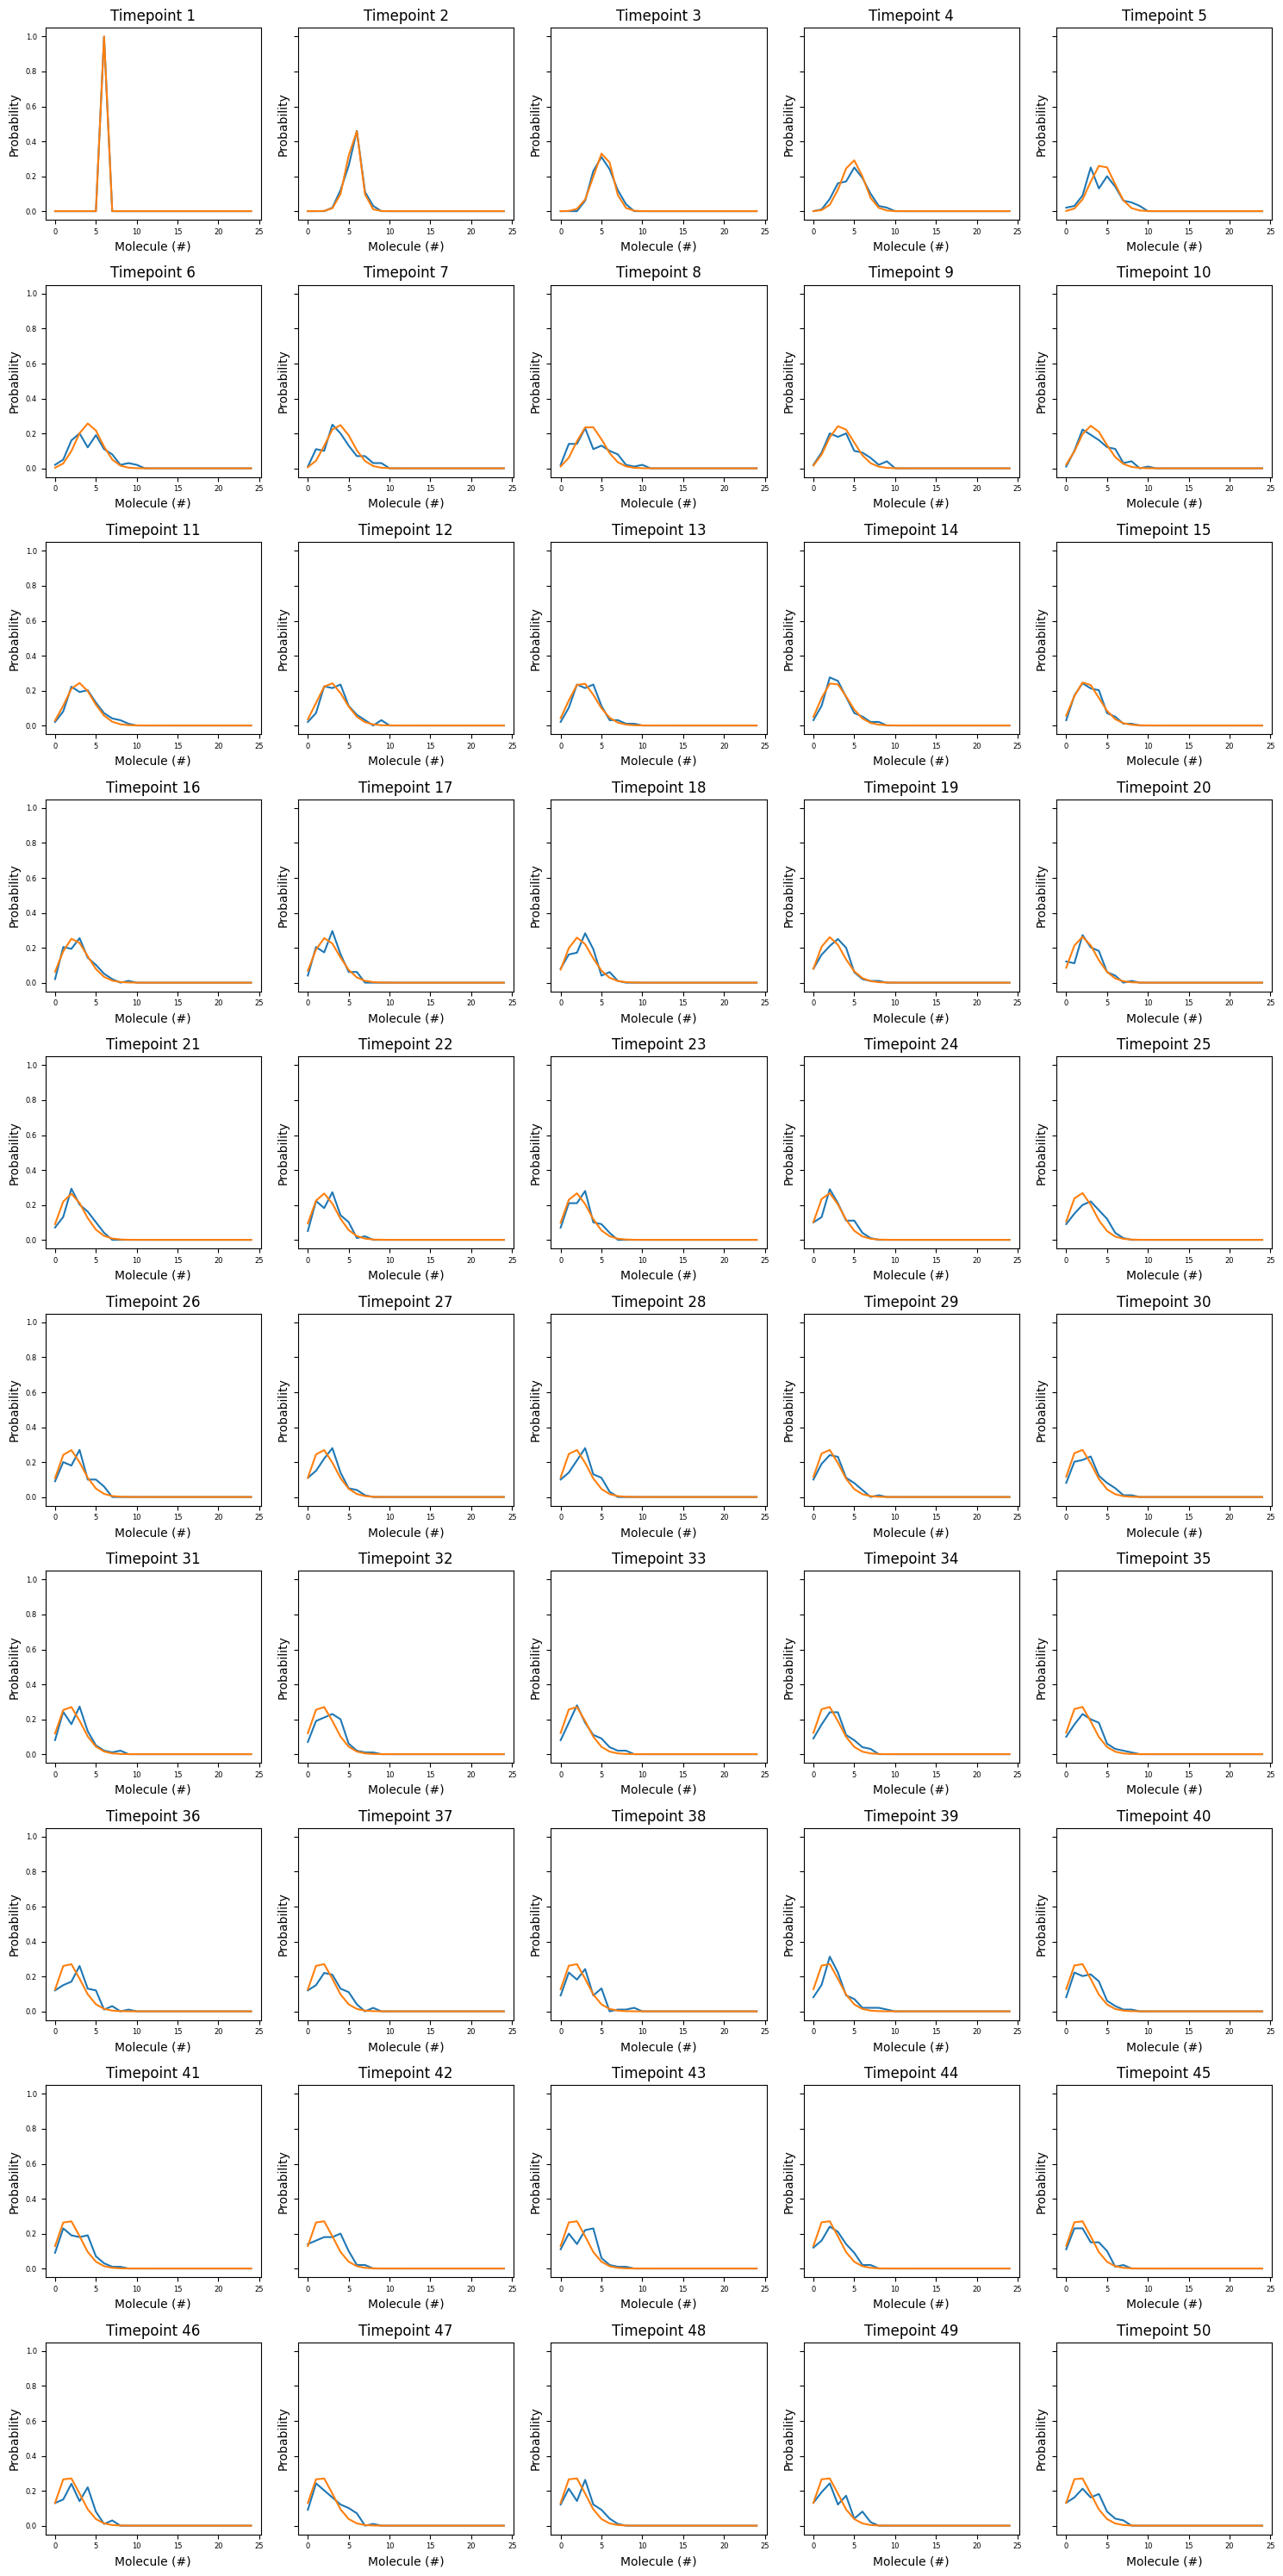

In [76]:
# Run CME with obtained parameters
x0 = popt_cme[0]
k1 = popt_cme[1]
k2 = popt_cme[2]
cme_solution = cme_model(trajectory_times, x0,k1,k2,max_molecules)

# Remove sink state from CME solution
usable_cme_solution = cme_solution[:,0:max_molecules]

# Create normalized experimental data histograms
data_hist = []
for t_idx in range(len(trajectory_times)):
  temp, _ = np.histogram(experimental_results[:,t_idx], bins=max_molecules,range=(0,max_molecules), density = True)
  data_hist.append(temp)
data_hist = np.array(data_hist)

# Create figure with subplots
n_cols = 5
n_rows = int(np.ceil(len(trajectory_times) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3), sharey=True)

axes = axes.flatten()
# Iterate over time points and plot distributions
for i, ax in enumerate(axes):
    ax.plot(data_hist[i,0:25], label="Experiment")
    ax.plot(usable_cme_solution[i,0:25], label="CME")
    ax.set_title(f"Timepoint {i+1}")
    ax.set_xlabel("Molecule (#)")
    ax.set_ylabel("Probability")
    #ax.set_aspect('equal', adjustable='box')  # square axes
    ax.tick_params(labelsize=6)

plt.tight_layout()
plt.show()